In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sys.path.append('..')

from dataset import Dataset, DatasetIndex, B, V
from detection_mnist import DetectionMnist
from faster_rcnn import FRCNNModel
%matplotlib inline

In [2]:
IMAGE_SHAPE = (128, 256)

In [3]:
ind = DatasetIndex(np.arange(1000))          # index for images
mnist = Dataset(ind, batch_class=DetectionMnist)   # Dataset with transform actions in NoisedMnist class
mnist.cv_split([0.9, 0.1])                      # divide it into train and test

In [4]:
import sys
import tensorflow as tf

sys.path.append('../task_03')

from dataset.dataset.models.tf.layers import conv_block
from dataset.dataset.models.tf import TFModel
from vgg import VGGModel

class FRCNNModel(TFModel):
    """LinkNet as TFModel"""
    def _build(self, inputs, *args, **kwargs):

        #n_classes = self.num_channels('masks')
        data_format = self.data_format('images')
        dim = self.spatial_dim('images')
        b_norm = self.get_from_config('batch_norm', True)

        conv = {'data_format': data_format}
        batch_norm = {'momentum': 0.1}

        kwargs = {'conv': conv, 'batch_norm': batch_norm}
        
        inp = inputs['reshaped_images']
        with tf.variable_scope('FRCNN'): # pylint: disable=not-context-manager
            net = VGGModel.fully_conv_block(dim, inp, b_norm, 'VGG6', **kwargs)
            net = conv_block(dim, net, 512, 3, 'ca', **kwargs)
            reg = conv_block(dim, net, 4*9, 1, 'ca', **kwargs)
            cls = conv_block(dim, net, 2*9, 1, 'ca', **kwargs)
        net = tf.concat([reg,cls], axis=-1, name='predictions')

In [5]:
placeholders_config = {
                       'images': {'shape': IMAGE_SHAPE + (1,),
                                 'dtype': 'float32',
                                 'data_format': 'channels_last',
                                 'name': 'reshaped_images'},
                
                       'reg_clsf': {'dtype': 'int32',
                                    'name': 'targets'},
                       }

In [6]:
model_config = {'inputs': placeholders_config,
                'batch_norm': False,
                'loss': 'softmax_cross_entropy',
                'optimizer': 'Adam'}

In [7]:
train_feed_dict = {'images': B('images'),
                   'reg_clsf': B('reg_clsf')}        

test_feed_dict = {'images': B('images'),
                  'reg_clsf': B('reg_clsf')}

In [8]:
IMAGE_SIZE = 128

train_pp = (mnist.train.p
            .init_model('static', FRCNNModel, 'frcnn', config=model_config)
            .load_images()
            .generate_multi_mnist(image_shape=IMAGE_SHAPE, max_dig=20)
            .create_anchors(IMAGE_SHAPE, (16,32))
            .create_bbox_batch(n_bboxes=10)
            .create_reg_cls()
            )

In [9]:
test_pp = (mnist.test.p
            .import_model('frcnn', train_pp)
            .init_variable('all_predictions', init_on_each_run=list)
            .load_images()
            .generate_multi_mnist(image_shape=IMAGE_SHAPE, max_dig=20)
            .create_anchors(IMAGE_SHAPE, (16,32))
            .create_bbox_batch(n_bboxes=10)
            .create_reg_cls()
            .predict_model('frcnn', 
                           fetches='predictions',
                           feed_dict=test_feed_dict,
                           save_to=V('all_predictions'), mode='a'))

In [10]:
res = train_pp.next_batch(20)

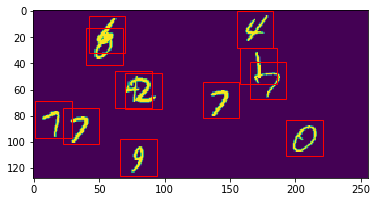

In [11]:
im = res.data.images[0]
bboxes = res.data.bboxes[0]

fig, ax = plt.subplots(1)

ax.imshow(im)

for bbox in bboxes:    
    rect = patches.Rectangle((bbox[1], bbox[0]), bbox[2], bbox[3] ,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

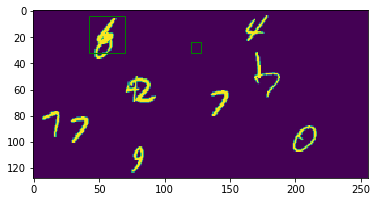

IoU: 0.0


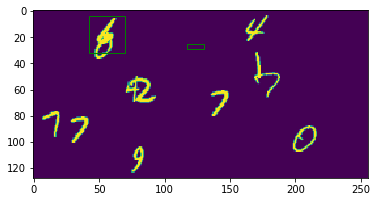

IoU: 0.0


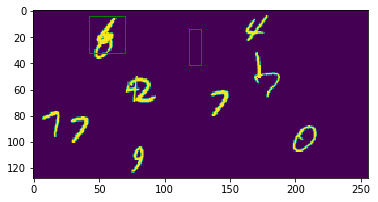

IoU: 0.0


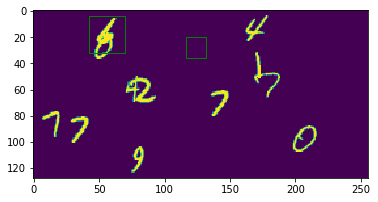

IoU: 0.0


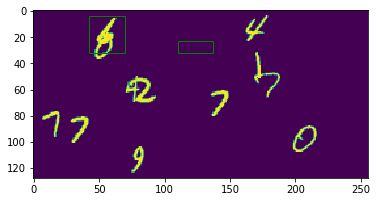

IoU: 0.0


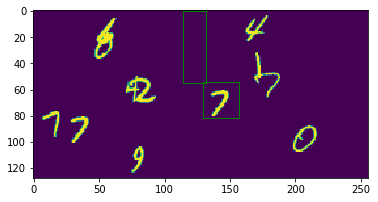

IoU: 0.00169396


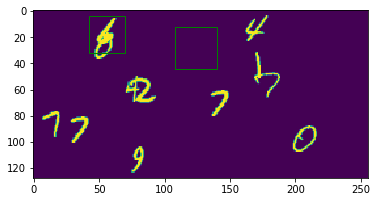

IoU: 0.0


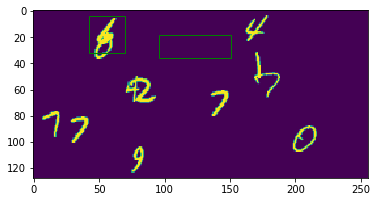

IoU: 0.0


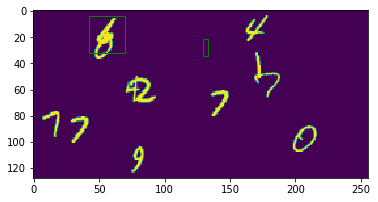

IoU: 0.0


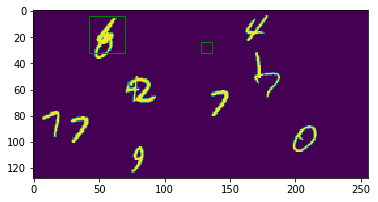

IoU: 0.0


In [13]:
anchors = res.data.anchors.reshape((16*32*9,4))
bboxes_best = res.data.reg.reshape((20, 512 * 9,4))[0]
ious = res.data.clsf.reshape((20, 512*9, 2))[:, :, 1]
import time

for i in range(1000,1010):
    fig, ax = plt.subplots(1)

    ax.imshow(im)
    bbox1 = anchors[i]
    bbox2 = bboxes_best[i]
    for bbox in [bbox1, bbox2]:
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2] ,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect)
    plt.show()
    print("IoU:", ious[0,i])
    time.sleep(0.01)